In [1]:
from google.colab import drive

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

project_seed = 2022
torch.manual_seed(project_seed)

In [2]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
!curl https://raw.githubusercontent.com/ggonzalesd/3DReconstruction/main/datatomodel.npy > datatomodel.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  256k  100  256k    0     0   764k      0 --:--:-- --:--:-- --:--:--  764k


In [5]:
models = np.load("datatomodel.npy", allow_pickle=True).item()

In [6]:
#@title Default title text
PATH = "/content/drive/MyDrive/ml-project4/" #@param {type:"string"}

PATH_CHECKPOINTS_GEN = PATH + "gen/"
PATH_CHECKPOINTS_DISC = PATH + "disc/"
PATH_IMG = PATH + "img/"

criterion = nn.BCEWithLogitsLoss()

#@title Default title text
device = "cuda" #@param {type:"string"}

models_x = [torch.from_numpy(np.array([model])*2 -1).float().to(device) for model in models['x']]
models_y = [torch.from_numpy(np.array([model])*2 -1).float().to(device) for model in models['y']]


# PLOTS

In [ ]:
def display_disc(voxel_disc):
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels((voxel_disc>0.5) * (voxel_disc<0.7) , facecolors='red', alpha=0.1)
    ax.voxels((voxel_disc>=0.7) * (voxel_disc<0.85) , facecolors='yellow', alpha=0.4)
    ax.voxels((voxel_disc>=0.85) , facecolors='lime')
    plt.show()

In [ ]:
def plot_epoch(indata, fakedata, targetdata, save_=False, num=0):
    fig=plt.figure()
    fig.set_size_inches(6, 3)
    ax1=fig.add_subplot(1,2,1,projection='3d')
    ax2=fig.add_subplot(1,2,2,projection='3d')

    ax1.set_title("Input")
    ax2.set_title("Fake")

    ax1.voxels(indata>0, facecolors='yellow')
    ax2.voxels(fakedata>0, facecolors='red')
    if save_:
        plt.savefig(PATH_IMG + f"out_{num}.png")
    else:
        plt.show()

# GAN

## Downsamples and Upsamples

In [7]:
def downsample(inchan, outchan, batch=True, kernel_size=4, stride=1):
    out = nn.Sequential()
    out.append(
        nn.Conv3d(
            inchan,
            outchan,
            kernel_size=kernel_size,
            stride=stride,
            bias=not batch
        )
    )
    if batch:
        out.append(nn.BatchNorm3d(outchan))
    out.append(nn.LeakyReLU(negative_slope=0.02))
    return out

In [8]:
def upsample(inchan, outchan, dropout=False, kernel_size=4, stride=1):
    out = nn.Sequential()
    out.append(
        nn.ConvTranspose3d(
            inchan,
            outchan,
            kernel_size=kernel_size,
            stride=stride,
            bias=False
        )
    )
    out.append(nn.BatchNorm3d(outchan))
    if dropout:
        out.append(nn.Dropout3d(0.5))
    out.append(nn.ReLU())
    return out

## Generator y Discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ff = 10

        self.d1 = downsample(1, ff, batch=False)                     # 16, 29, 29, 29
        self.d2 = downsample(ff, 2*ff)                               # 32, 26, 26, 26
        self.d3 = downsample(2*ff, 4*ff, stride=2)                   # 64, 12, 12, 12
        self.d4 = downsample(4*ff, 4*ff, stride=2)                   # 64,  5,  5,  5
        self.d5 = downsample(4*ff, 4*ff, stride=2, batch=False)       # 64,  1,  1,  1

        self.u1 = upsample(4*ff, 4*ff, dropout=False, kernel_size=5) # 64,  5,  5,  5
        self.u2 = upsample(8*ff, 4*ff, dropout=False, stride=2)      # 64, 12, 12, 12
        self.u3 = upsample(8*ff, 2*ff, stride=2)                     # 64, 26, 26, 26
        self.u4 = upsample(4*ff, ff)                                  # 16, 29, 29, 29

        self.out = nn.ConvTranspose3d(2*ff, 1, kernel_size=4)
        self.act = nn.Tanh()
    
    def forward(self, x):
        s = []

        x = self.d1(x)
        s.append(x)
        x = self.d2(x)
        s.append(x)
        x = self.d3(x)
        s.append(x)
        x = self.d4(x)
        s.append(x)
        x = self.d5(x)

        x = self.u1(x)
        x = torch.cat((x, s[-1]), dim=1)
        x = self.u2(x)
        x = torch.cat((x, s[-2]), dim=1)
        x = self.u3(x)
        x = torch.cat((x, s[-3]), dim=1)
        x = self.u4(x)
        x = torch.cat((x, s[-4]), dim=1)

        return self.act(self.out(x))

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.d1 = downsample(2, 16, batch=False)
        self.d2 = downsample(16, 32)
        self.d3 = downsample(32, 64, stride=2)
        self.d4 = downsample(64, 64, stride=2)
        self.d5 = downsample(64, 64, stride=2)

        self.out = nn.ConvTranspose3d(64, 1, kernel_size=4)
        self.act = nn.Sigmoid()

    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)

        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)

        return self.act(self.out(x))

# Load model

In [21]:
#@title Default title text
epoch_model = 590 #@param {type:"integer"}
# Load Model from Drive
gen = Generator().to(device)
disc = Discriminator().to(device)

gen.load_state_dict(torch.load(PATH + f"gen/gen_{epoch_model}.pth"))
disc.load_state_dict(torch.load(PATH + f"disc/disc_{epoch_model}.pth"))

<All keys matched successfully>

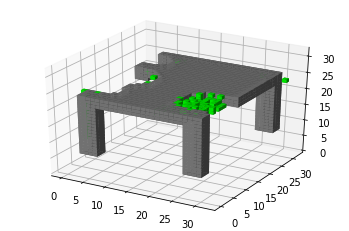

In [22]:
x1 = torch.stack([models_x[0],])
y1 = torch.stack([models_y[0],])
fake = gen(x1)

x1 = x1[0][0].detach().cpu().numpy() > 0
y1 = y1[0][0].detach().cpu().numpy() > 0
fake = fake[0][0].detach().cpu().numpy() > 0

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(x1, facecolors='gray')
ax.voxels(fake&~x1 , facecolors='lime')
plt.show()

In [29]:
x1 = torch.stack(models_x)
fakes = gen(x1)
fakes = fakes.detach().cpu().numpy() > 0

In [30]:
fakes.shape

(4, 1, 32, 32, 32)

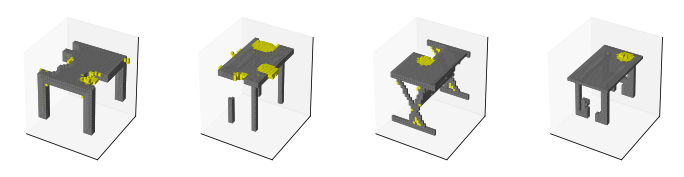

In [33]:
fig = plt.figure()
fig.set_size_inches(12, 3)
for i, model in enumerate(fakes):
    ax = fig.add_subplot(1,4,i+1,projection='3d')
    ax.voxels(models['x'][i], facecolors='gray')
    ax.voxels(model[0]&~models['x'][i], facecolors='yellow')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.show()

In [23]:
!pip3 install trimesh
import trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 663 kB 24.4 MB/s 


In [24]:
for i, model_t in enumerate([x1, fake, y1, fake&~x1]):
    model_fractured = model_t
    mesh = trimesh.voxel.ops.matrix_to_marching_cubes(matrix=model_fractured, pitch=1.0)
    mesh.merge_vertices()
    mesh.remove_duplicate_faces()
    mesh.apply_scale(scaling=0.25)
    trimesh.repair.fill_holes(mesh)
    trimesh.repair.fix_inversion(mesh)
    trimesh.repair.fix_winding(mesh)

    trimesh.exchange.export.export_mesh(mesh=mesh, file_obj=f"mesh_{i}.stl", file_type='stl')

/usr/local/lib/python3.7/dist-packages/trimesh/voxel/ops.py:142: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  spacing=pitch)
